## I believe the American healthcare insurance  system makes medical data held in America more reliable. Therefore, in this notebook, I have studied the trend of COVID infection with the data of the American healthcare system. Is winter really coming again?
## The most crucial question on my mind is, "Are COVID booster shots really necessary?"

## Of course, since it is about health, I have to say that legally this notebook is an experiment and does not constitute sufficient evidence, therefore the results are not advisory.

<img src = "https://i.ytimg.com/vi/8LFAOU8h9Jw/maxresdefault.jpg">

In [1]:
# Filtering Warnings

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import itertools
import time
from random import random
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from pycaret.time_series import *

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
plt.style.use('ggplot') 

import seaborn as sns   

from tqdm.notebook import trange as notebook_trange
from tqdm import tqdm, trange

* First Case in US :  January 21 2020
* First Day of Stay at Home Order : March 19 2020 (California) 
* End Day of Stay at Home Order : June 15 2021 (California) 

In [2]:
first_case = pd.to_datetime(np.array("01/21/2020"))
first_lockdown = pd.to_datetime(np.array("03/19/2020"))
first_vaccine = pd.to_datetime(np.array("14/12/2020"))
last_lockdown = pd.to_datetime(np.array("15/06/2021"))
first_delta = pd.to_datetime(np.array("01/07/2021"))
first_omicron = pd.to_datetime(np.array("30/11/2021"))

In [3]:
# COVID Data
covid = pd.read_csv("WHO-COVID-19-global-data.csv")
covid['date'] = pd.to_datetime(covid['Date_reported'], format="%Y-%m-%d")
covid['date'] = pd.to_datetime(covid['date'], unit='s')
covid.drop(columns=["Date_reported","WHO_region","Country"],inplace=True)
covid = covid[(covid.Country_code=="US")]#&(covid.date<='9/9/2021')]
covid.New_cases = covid.New_cases.apply(lambda x: x if x >=0 else 0)
covid.New_deaths = covid.New_deaths.apply(lambda x: x if x >=0 else 0)
covid

,Country_code,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,date
220124,US,0,0,0,0,2020-01-03
220125,US,0,0,0,0,2020-01-04
220126,US,0,0,0,0,2020-01-05
220127,US,0,0,0,0,2020-01-06
220128,US,0,0,0,0,2020-01-07
...,...,...,...,...,...,...
221093,US,10548,92953690,19,1033207,2022-08-29
221094,US,14927,92968617,30,1033237,2022-08-30
221095,US,91651,93060268,230,1033467,2022-08-31
221096,US,156554,93216822,1252,1034719,2022-09-01


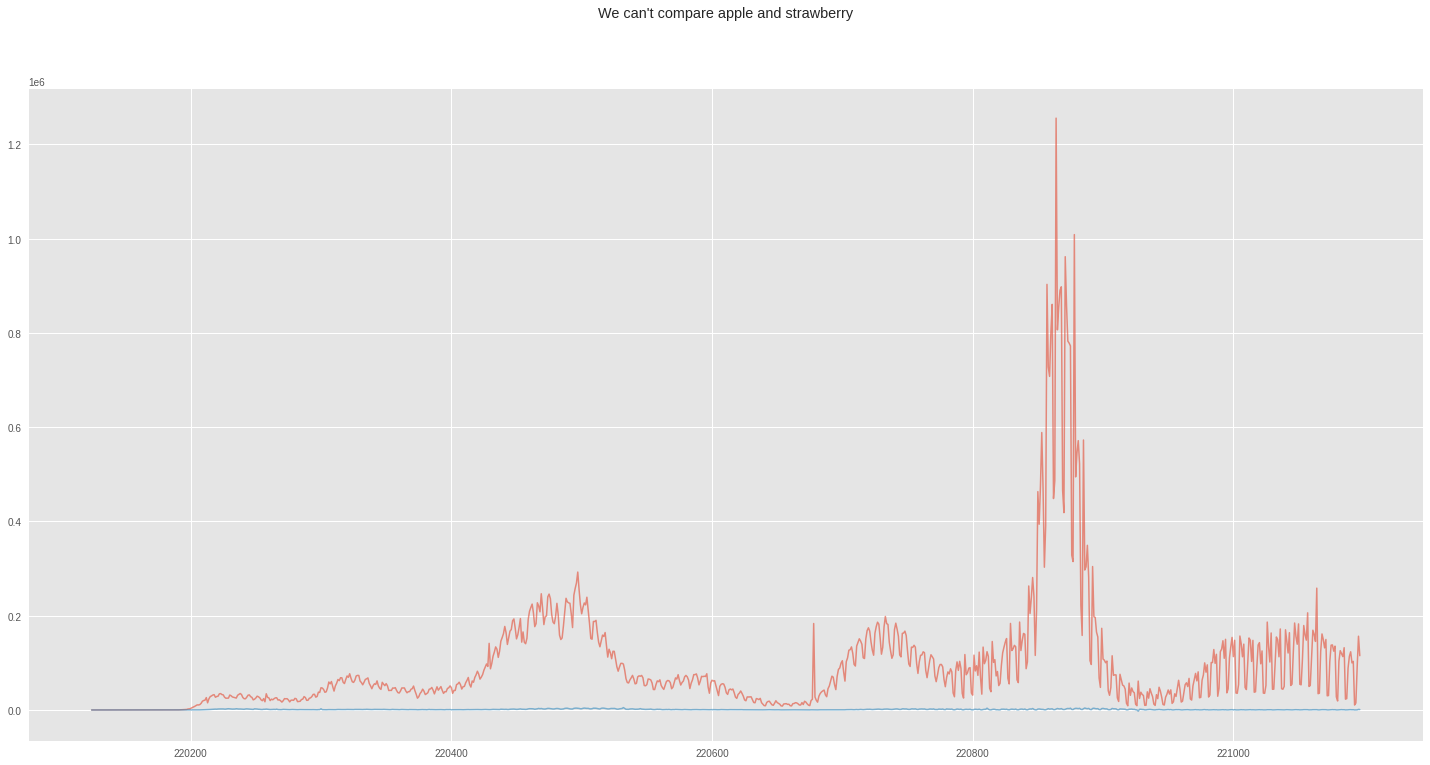

In [81]:
covid.New_cases.plot(alpha=.6,linewidth=1.5)
covid.New_deaths.plot(alpha=.6,linewidth=1.5)
plt.title("We can't compare apple and strawberry",y=1.1)
plt.show()

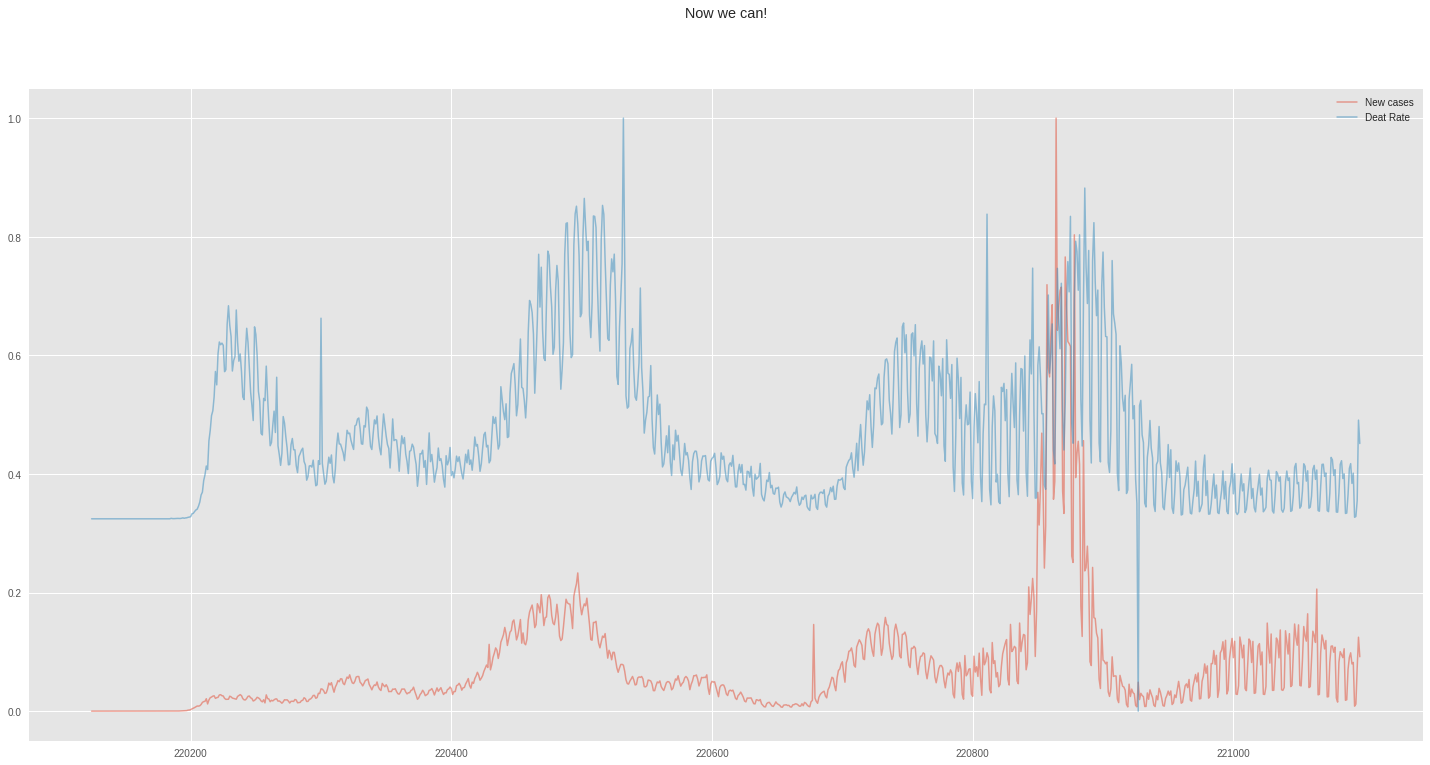

In [82]:
#
scaler = MinMaxScaler()
scaled_new_case = scaler.fit_transform(covid[["New_cases"]])
covid.New_cases = scaled_new_case
scaled_new_deaths = scaler.fit_transform(covid[["New_deaths"]])
covid.New_deaths = scaled_new_deaths
covid.New_cases.plot(alpha=0.5,linewidth=1.5,label="New cases")
covid.New_deaths.plot(alpha=0.5,linewidth=1.5,label="Deat Rate")
plt.title("Now we can!",y=1.1)
plt.legend()
plt.show()

### It is very useful to scale when comparing different attributes.
<img src="https://miro.medium.com/max/1200/1*yR54MSI1jjnf2QeGtt57PA.png" width=1000>

In [6]:
covid_death = covid[["date","New_deaths"]]
covid_death = covid_death[covid_death.New_deaths>0]
covid_death = covid_death.groupby('date').sum()
covid_death = covid_death



covid_case = covid[["date","New_cases"]]
covid_case = covid_case[covid_case.New_cases>0]
covid_case = covid_case.groupby('date').sum()
covid_case = covid_case

display(covid_case.head())
display(covid_death.head())

,New_cases
date,
2020-01-20,7.962804e-07
2020-01-25,3.981402e-06
2020-01-26,7.962804e-07
2020-01-28,7.962804e-07
2020-02-02,7.962804e-07


,New_deaths
date,
2020-02-29,0.000197
2020-03-02,0.000197
2020-03-04,0.001180
2020-03-05,0.000590
2020-03-06,0.000393


<AxesSubplot:xlabel='date'>

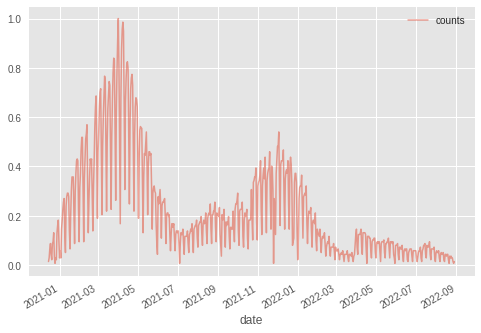

In [7]:
vaccine = pd.read_csv("vaccine.csv")
vaccine = vaccine[vaccine.Code=="USA"]
vaccine['date'] = pd.to_datetime(vaccine['Day'], format="%Y-%m-%d")
vaccine['date'] = pd.to_datetime(vaccine['date'], unit='s')
# Count for per hundred people
vaccine.rename(columns={"total_vaccinations_per_hundred":"counts"},inplace=True)
vaccine.drop(columns=["Entity","Code","Day"],inplace=True)
vaccine["counts"] = vaccine["counts"].diff()
vaccine.counts = vaccine.counts.apply(lambda x: x if x >=0 else 0)
scaled_counts = scaler.fit_transform(vaccine[["counts"]])
vaccine.counts = scaled_counts
vaccine.sort_values(by="date",ascending=True,inplace=True)
vaccine.reset_index(drop="index",inplace=True)
vaccine = vaccine.set_index('date')
vaccine.index = pd.to_datetime(vaccine.index)
vaccine = vaccine[vaccine.counts>0]
vaccine.plot(alpha=0.5,linewidth=1.5)

### The number of daily vaccinations has been decreased day by day. However, the number of people who have become immunized (passive) has increased accordingly, and there are even those who have become active immunity without the vaccine.

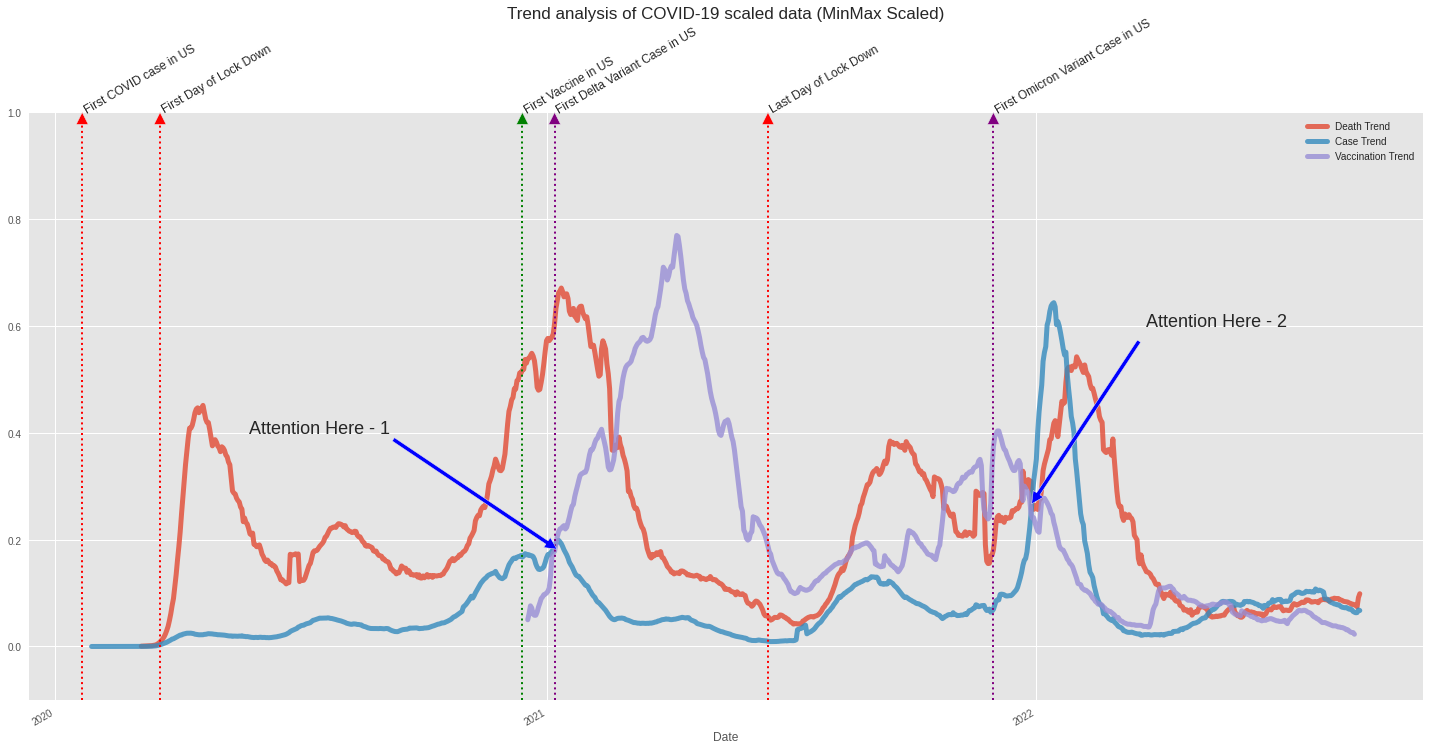

In [14]:
covid_death_decomposition = sm.tsa.seasonal_decompose(covid_death["New_deaths"],
                                                      period = 7,
                                                      model = "multiplicative") 



covid_case_decomposition = sm.tsa.seasonal_decompose(covid_case["New_cases"],
                                                      period = 7,
                                                      model = "multiplicative") 


vaccine_decomposition = sm.tsa.seasonal_decompose(vaccine["counts"], 
                                                  period = 7, 
                                                  model = "multiplicative") 





covid_death_decomposition.trend.plot(label = "Death Trend",
                                     alpha = .8,
                                     linewidth=5)

covid_case_decomposition.trend.plot(label= "Case Trend",
                                    alpha = .8,
                                    linewidth=5)

vaccine_decomposition.trend.plot(label= "Vaccination Trend",
                                 alpha = .8,
                                 linewidth=5)


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (25, 12)

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.YearLocator(base = 1, month = 1, day = 1))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.axvline(x=first_case, color='red',
            alpha = 1, ls=':', lw=2,)

plt.annotate('First COVID case in US',
             xy=(first_case,1),
             xytext=(first_case,1),
             arrowprops=dict(facecolor='red',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=first_lockdown, color='red',
            alpha = 1, ls=':', lw=2,)                             

plt.annotate('First Day of Lock Down',
             xy=(first_lockdown,1),
             xytext=(first_lockdown,1),
             arrowprops=dict(facecolor='red',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=first_vaccine, color='green',
            alpha = 1, ls=':', lw=2,)

plt.annotate('First Vaccine in US',
             xy=(first_vaccine,1),
             xytext=(first_vaccine,1),
             arrowprops=dict(facecolor='green',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=last_lockdown, color='red',
            alpha = 1, ls=':', lw=2,)

plt.annotate('Last Day of Lock Down',
             xy=(last_lockdown,1),
             xytext=(last_lockdown,1),
             arrowprops=dict(facecolor='red',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)                             

plt.axvline(x=first_delta, color='purple',
            alpha = 1, ls=':', lw=2,)


plt.annotate('First Delta Variant Case in US',
             xy=(first_delta,1),
             xytext=(first_delta,1),
             arrowprops=dict(facecolor='purple',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)            


plt.axvline(x=first_omicron, color='purple',
            alpha = 1, ls=':', lw=2,)

plt.annotate('First Omicron Variant Case in US',
             xy=(first_omicron,1),
             xytext=(first_omicron,1),
             arrowprops=dict(facecolor='purple',
                             shrink=0.01),
             fontsize = 12,
             rotation = 30)


plt.annotate("Attention Here - 2",
             xy=(pd.to_datetime(np.array("12/24/2021")),.25),
             xytext=(pd.to_datetime(np.array("03/24/2022")),.6),
             arrowprops=dict(facecolor='blue',
                             shrink=0.05,
                             alpha=1),
             fontsize = 18,
             rotation = 0)

plt.annotate("Attention Here - 1",
             xy=(pd.to_datetime(np.array("01/10/2021")),.18),
             xytext=(pd.to_datetime(np.array("05/24/2020")),.4),
             arrowprops=dict(facecolor='blue',
                             shrink=0.01,
                             alpha=1),
             fontsize = 18,
             rotation = 0,)

             
plt.xlabel("Date")
plt.ylim(-0.1,1)
plt.gcf().autofmt_xdate() # Rotation
plt.legend( fontsize=10, title_fontsize=25)
plt.title("Trend analysis of COVID-19 scaled data (MinMax Scaled)", y=1.15, fontsize=17)
plt.show()

### **The impact of COVID vaccination on the case trend and mortality trend is so clear. When the vaccination trend decreases, the trend of new case and death trend increases on first point, and second point had been vice versa. Winter is coming! Don't forget booster dose.**
<img src = "/home/izzet/Desktop/covid_boster_shoot/resized booster shot.png" >

## Lets forecast the number of COVID case for next months.

In [93]:
# COVID Data
covid = pd.read_csv("WHO-COVID-19-global-data.csv")
covid['date'] = pd.to_datetime(covid['Date_reported'], format="%Y-%m-%d")
covid['date'] = pd.to_datetime(covid['date'], unit='s')
covid.drop(columns=["Date_reported","WHO_region","Country"],inplace=True)
covid = covid[(covid.Country_code=="US")]#&(covid.date<='9/9/2021')]
covid_case = covid[["date","New_cases"]]
covid_case = covid_case.groupby('date').sum()
covid_case = covid_case.asfreq('D')
covid_case

,New_cases
date,
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-07,0
...,...
2022-08-29,10548
2022-08-30,14927
2022-08-31,91651


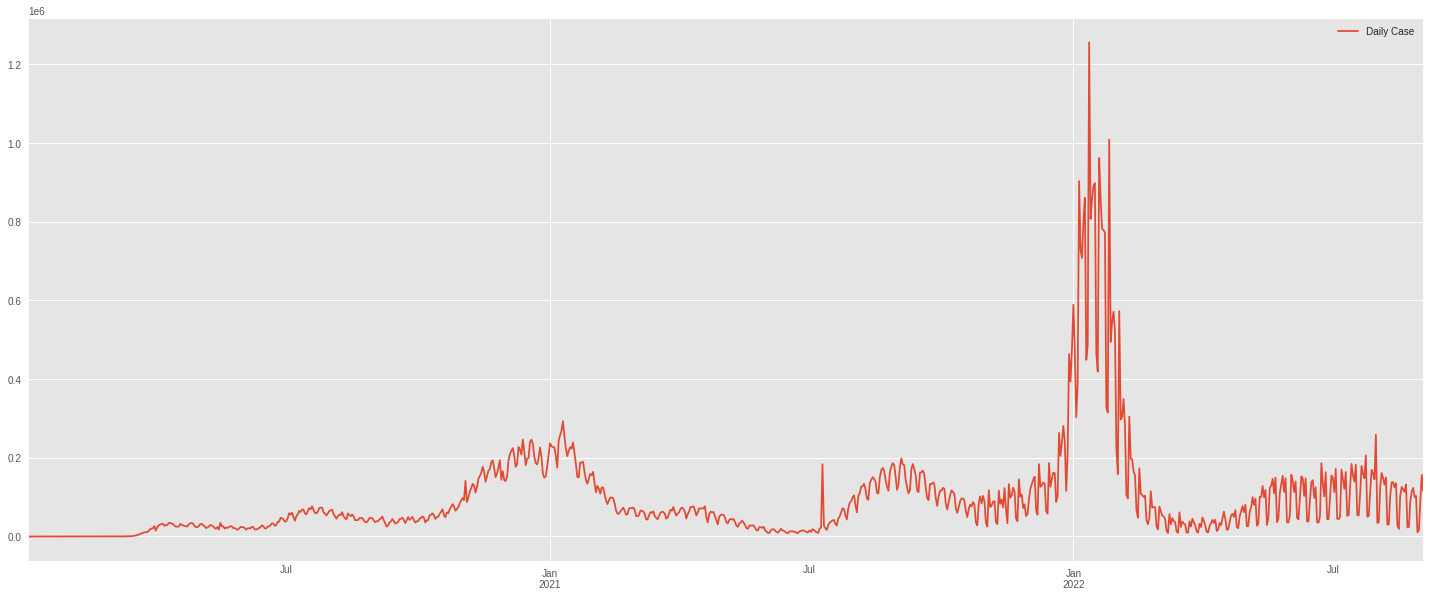

In [94]:
from prophet import Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

# general settings
class CFG:
    data_folder = ''
    img_dim1 = 25
    img_dim2 = 10


xdat = covid[["date","New_cases"]].rename(columns={"date": "ds", "New_cases": "y"})
xdat.set_index('ds').rename(columns={"y":"Daily Case"}).plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

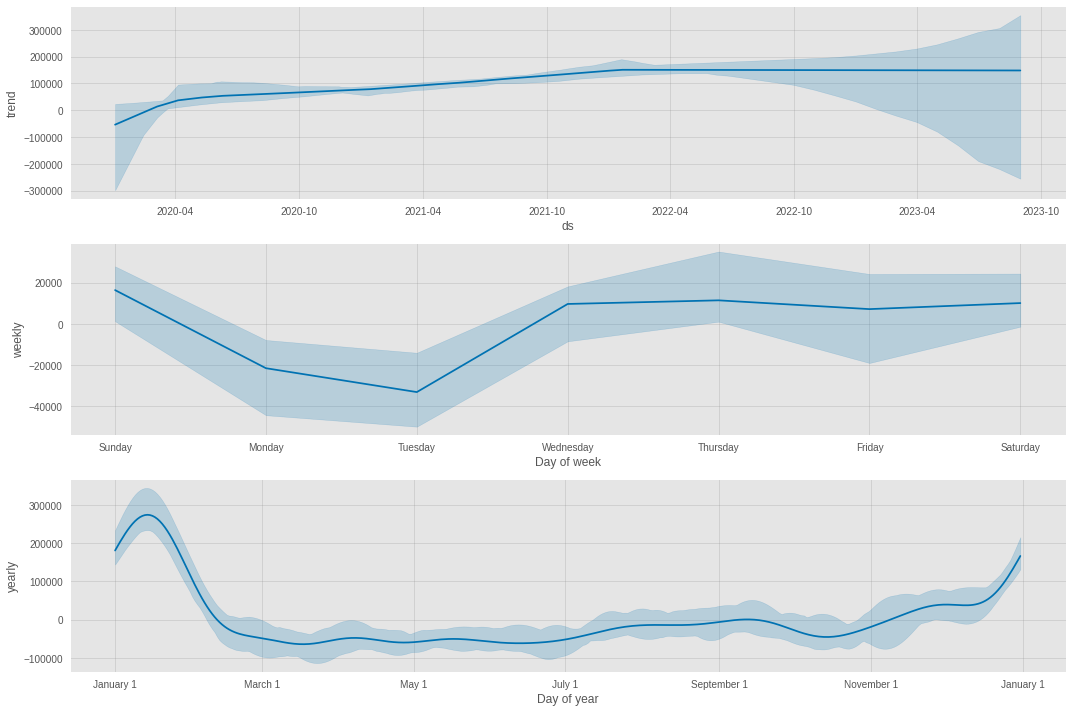

In [70]:
# we reduce the dataset size for speed - the only requirement while doing is to keep at least two complete cycles 
# for each seasonality we intend to fit 
m = Prophet(mcmc_samples = 30,
            weekly_seasonality=True,
            interval_width = 0.95).fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

#### As you can understand from the plot above, when the months are compared, the highest increases are seen as January and February. Looking at the overall trend, it seems more likely that the trend will be down. Hopefully that will be.

### NeuralProphet
* ##### NeuralProphet is a Neural Network based PyTorch implementation of a user-friendly time series forecasting tool for practitioners. This is heavily inspired by Prophet, which is the popular forecasting tool developed by Facebook. NeuralProphet is developed in a fully modular architecture which makes it scalable to add any additional components in the future. Our vision is to develop a simple to use forecasting tool for users while retaining the original objectives of Prophet such as interpretability, configurability and providing much more such as the automatic differencing capabilities by using PyTorch as the backend.

<img src="https://miro.medium.com/max/1838/1*g_clFunR6GbWU1rL2iGugA.png">

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 196


  0%|          | 0/125 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.95E-02, min: 1.10E+00


  0%|          | 0/125 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.57E-02, min: 1.48E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.78E-02
Epoch[196/196]: 100%|██████████| 196/196 [00:46<00:00,  4.18it/s, SmoothL1Loss=0.0358, MAE=4.01e+4, RMSE=6.15e+4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


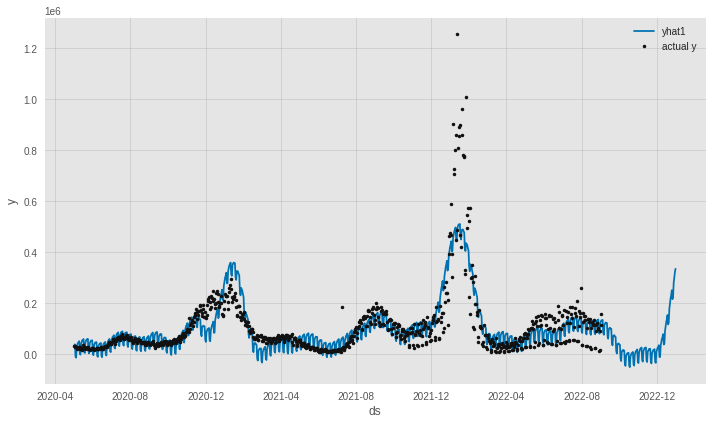

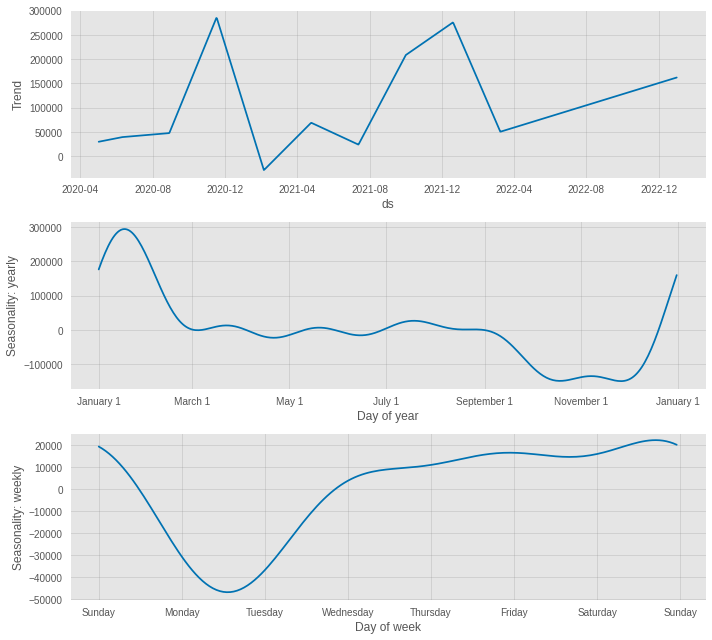

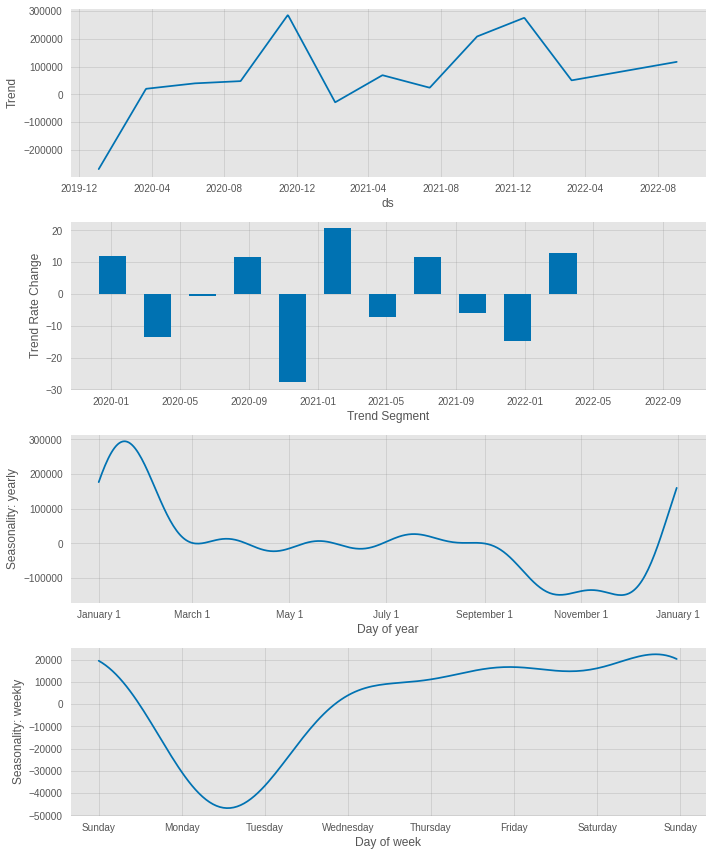

In [80]:
from neuralprophet import NeuralProphet

model = NeuralProphet(weekly_seasonality = True)
model.fit(xdat,freq="D")

# forecast
future = model.make_future_dataframe(xdat, periods=120, n_historic_predictions=len(xdat)-120)
forecast = model.predict(future)
fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)
fig_model = model.plot_parameters()

# Conclusion
## 1 - Probably the trend has decreased and according to our analysis it will probably not be a trouble for human beings.
## 2 - However, these models are supervised, this mean that they are modeled with observed data. Let me give an example.

In [106]:
previous_omicron = xdat.iloc[:697] # What happened after the 277 days
previous_omicron

,ds,y
220124,2020-01-03,0
220125,2020-01-04,0
220126,2020-01-05,0
220127,2020-01-06,0
220128,2020-01-07,0
...,...,...
220816,2021-11-25,101010
220817,2021-11-26,106782
220818,2021-11-27,72215
220819,2021-11-28,81629


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 218


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.10E-01, min: 1.64E+00


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.10E-01, min: 3.79E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.64E-01
Epoch[218/218]: 100%|██████████| 218/218 [00:41<00:00,  5.22it/s, SmoothL1Loss=0.00846, MAE=1.9e+4, RMSE=2.52e+4, RegLoss=0, MAE_val=1.13e+5, RMSE_val=2.19e+5, SmoothL1Loss_val=0.327] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 884 historic forecasts, reduced to 697.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.873% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.873% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequen

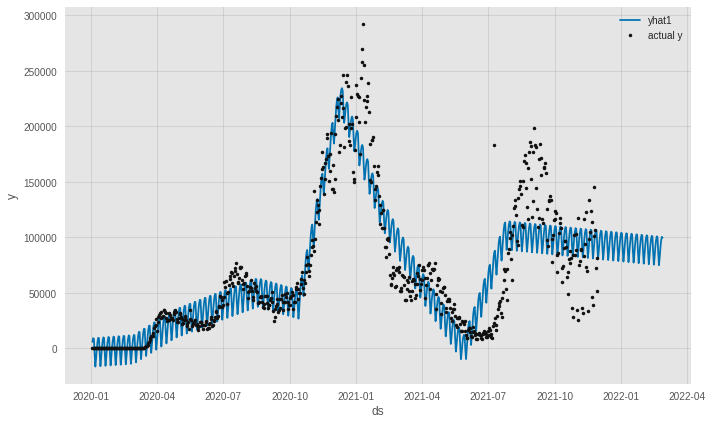

In [144]:

model = NeuralProphet(daily_seasonality = True,
                      weekly_seasonality=True)
model.fit(previous_omicron,freq="D",validation_df=xdat.iloc[697:])
# forecast
future = model.make_future_dataframe(previous_omicron, periods=90, n_historic_predictions=len(xdat)-90)
forecast = model.predict(future)
fig_forecast = model.plot(forecast)

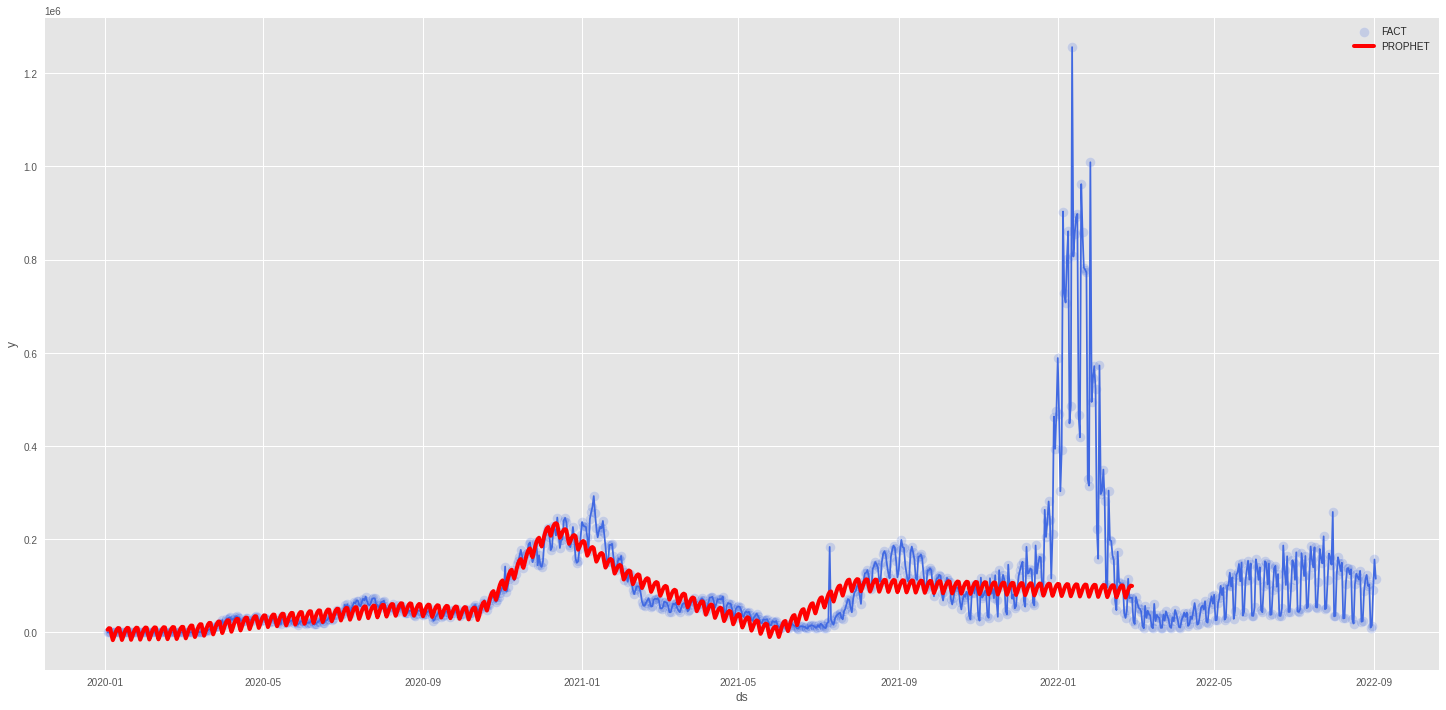

In [149]:
sns.scatterplot(data=xdat,x="ds",y="y",color="royalblue",s=100,alpha=.2,label="FACT")
sns.lineplot(data=xdat,x="ds",y="y",color="royalblue")
sns.lineplot(data=forecast,x="ds",y="yhat1",color= "red",label="PROPHET",linewidth=4)
plt.legend()
plt.show()

## 3 - In the forecasting above, the algorithm couldn't predict the omicron variant, nor can it! In short, model name is prophet but we are not prophets, if definite results were achieved with such models, I would be drinking my mojito on a beautiful beach instead of writing this.
## 4 - Conclusion, I'm going to go next week and get my booster shot. It is not clear what will happen. The uptrends in January and February seemed more accurate for me.
## Stay in health !!